In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import MicroTools as micro
from MicroTools import plot_tools as pt
import MiniTools as mini
import param_scan

from importlib.resources import open_text


In [16]:
dic_osc_app = param_scan.load_scan_data('fit_data/MH_apponly.pkl')
dic_osc_full = param_scan.load_scan_data('fit_data/MH_numu_MC_keep_numu_norm.pkl')
dic_dec_full = param_scan.load_scan_data('fit_data/MH_decay_test_30.pkl')

bf_osc_app = param_scan.get_best_fit_point(dic_osc_app)
bf_osc_full = param_scan.get_best_fit_point(dic_osc_full)
bf_dec_full = param_scan.get_best_fit_point(dic_dec_full)

In [18]:
bf_dec_full

{'g': 2.395026619987486,
 'm4': 5.512889788770675,
 'Ue4Sq': 0.019765709878143814,
 'Um4Sq': 0.00818955581365116,
 'sin2theta': 0.000647,
 'dm4SQR': 30.391953823131978,
 'MiniApp_chi2': 30.33737655564948,
 'MicroApp_chi2': 111.43108354501508,
 'MicroApp_Asimov_chi2': 13.423682680765566,
 'MiniApp_deltachi2': 0.0,
 'MicroApp_deltachi2': 21.61626684265623,
 'MicroApp_Asimov_deltachi2': 10.616495036060645}

In [20]:
params_no_osc = {'g': 1e-10, 'Ue4Sq': 1e-10, 'Um4Sq': 1e-10, 'm4': 1}
rates_no_osc = param_scan.get_nue_rates(params_no_osc, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=False, decouple_decay=False, disappearance=True, energy_degradation=True, n_replications=1, undo_numu_normalization=False)

params_BEST_osc = {'g': 1e-5, 'Ue4Sq': 0.1, 'Um4Sq': 1e-2, 'm4': 1}
params_BEST_dec = {'g': 1, 'Ue4Sq': 0.1, 'Um4Sq': 3e-3, 'm4': 1e3}
rates_dic_osc_BEST = param_scan.get_nue_rates(params_BEST_osc, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=False, decouple_decay=False, disappearance=True, energy_degradation=True, n_replications=1, undo_numu_normalization=False)
rates_dic_decay_BEST = param_scan.get_nue_rates(params_BEST_dec, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=True, decouple_decay=False, disappearance=True, energy_degradation=True, n_replications=10, undo_numu_normalization=False)

params_solar_osc = {'g': 1e-3, 'Ue4Sq': 0.05, 'Um4Sq': 2e-2, 'm4': 1}
params_solar_dec = {'g': 1, 'Ue4Sq': 0.05, 'Um4Sq': 3e-3, 'm4': 1e3}
rates_dic_osc_solar = param_scan.get_nue_rates(params_solar_osc, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=False, decouple_decay=False, disappearance=True, energy_degradation=True, n_replications=1, undo_numu_normalization=False)
rates_dic_decay_solar = param_scan.get_nue_rates(params_solar_dec, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=True, decouple_decay=False, disappearance=True, energy_degradation=True, n_replications=10, undo_numu_normalization=False)

rates_dic_bf_osc_full = param_scan.get_nue_rates(bf_osc_full, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=False, decouple_decay=False, disappearance=True, energy_degradation=True, n_replications=1, undo_numu_normalization=False)
rates_dic_bf_dec_full = param_scan.get_nue_rates(bf_dec_full, oscillations=True, use_numu_MC=True, include_antineutrinos=True, decay=True, decouple_decay=False, disappearance=True, energy_degradation=True, n_replications=10, undo_numu_normalization=False)

## MiniBooNE nu_e sample

In [21]:
# settings for Mini Figs
TOTAL_RATE = False
INCLUDE_MB_LAST_BIN = False
STACKED = False
PLOT_FAMILY=False
PATH_PLOTS = 'plots/event_rates/'

PAPER_TAG = r'KHZ\,2024'

In [22]:
Weight_nue_flux = mini.apps.reweight_MC_to_nue_flux(
            param_scan.Etrue_nue, param_scan.Weight_nue, mode="fhc"
        )

MC_nue_bkg_intrinsic = np.dot(
                param_scan.fast_histogram(
                    param_scan.Etrue_nue, bins=param_scan.e_prod_e_int_bins, weights=Weight_nue_flux
                )[0],
                mini.apps.migration_matrix_official_bins_nue_11bins,
            )

In [23]:
len(rates_dic_osc_solar['MC_nue_app'])*2 + len(rates_dic_osc_solar['MC_numu_bkg_total_w_dis'])*2

38

In [24]:
import scipy
from scipy.stats import norm
def get_pval(rates_dic, ndof=8.7):
    MB_chi2 = mini.fit.chi2_MiniBooNE_combined(
                MC_nue_app=rates_dic["MC_nue_app"],
                MC_nuebar_app=rates_dic["MC_nuebar_app"],
                MC_nue_dis=rates_dic["MC_nue_bkg_total_w_dis"],
                MC_numu_dis=rates_dic["MC_numu_bkg_total_w_dis"],
                MC_nuebar_dis=rates_dic["MC_nuebar_bkg_total_w_dis"],
                MC_numubar_dis=rates_dic["MC_numubar_bkg_total_w_dis"],
                year="2020",
            )
    return scipy.stats.chi2.sf(MB_chi2, ndof)


def get_pval_nu(rates_dic, ndof=8.7):
    MB_chi2 = mini.fit.chi2_MiniBooNE_combined(
                MC_nue_app=rates_dic["MC_nue_app"],
                MC_nue_dis=rates_dic["MC_nue_bkg_total_w_dis"],
                MC_numu_dis=rates_dic["MC_numu_bkg_total_w_dis"],
                year="2020",
            )
    return scipy.stats.chi2.sf(MB_chi2, ndof)


# import the necessary module
# define the chi-square probability
pval, pval_nu = get_pval(rates_dic_decay_solar, ndof=38 - 2), get_pval(rates_dic_decay_solar, ndof=38/2 - 1)

# calculate the number of standard deviations # NOTE: lazy... I can't remember how to relate the two....
# std_devs, std_devs_nu = np.sqrt(scipy.stats.chi2.ppf(1-pval, 38-2)), np.sqrt(scipy.stats.chi2.ppf(1-pval_nu, 38/2-1))

print(pval, pval_nu)

0.33909874991835215 0.0029086280454269416


In [25]:
def make_rate_plot(rates, params, name='3+1_osc'):
    fig, ax1 = pt.std_fig(figsize=(3.3*1.2,2*1.2))
    bins = param_scan.MB_Ereco_official_bins
    bin_w = np.diff(bins)
    bin_c = bins[:-1] + bin_w/2

    ######################################
    # MiniBooNE 
    if TOTAL_RATE:
        units= 1
        ax1.set_ylabel(r"Events")
    else:
        units = 1/micro.bin_width
        ax1.set_ylabel(r"Events/MeV")

    nue_data = np.genfromtxt(
        open_text(
            f"MiniTools.include.MB_data_release_2020.combined",
            f"miniboone_nuedata_lowe.txt",
        )
    )
    nue_tot_bkg = np.genfromtxt(
                open_text(
                    f"MiniTools.include.MB_data_release_2020.combined",
                    f"miniboone_nuebgr_lowe.txt",
                )
            )
    nue_bkg_midID = nue_tot_bkg - MC_nue_bkg_intrinsic

    # plot data
    pt.data_plot(ax1, 
            X=bin_c,
            Y=nue_data*units, 
            xerr=bin_w/2, 
            yerr=np.sqrt(nue_data)*units,
            zorder=3)


    ax1.hist(bins[:-1],
            bins=bins,
            weights=(nue_tot_bkg)*units,
            edgecolor='black',
            lw=0.5,
            ls=(1,(2,1)),
            label=r'unoscillated total bkg',
            histtype='step',
            zorder=1.6)
    ax1.hist(bins[:-1],
            bins=bins,
            weights=(nue_bkg_midID)*units,
            edgecolor='black',
            facecolor='lightgrey',
            lw=0.5,
            label=r'misID bkg',
            histtype='stepfilled',
            zorder=2)
    ax1.hist(bins[:-1],
            bins=bins,
            # weights=(nue_tot_bkg)*units,
            weights=rates['MC_nue_bkg_total_w_dis']*units,
            edgecolor='black',
            facecolor='peachpuff',
            lw=0.5,
            label=r'$\nu_e$ disappearance',
            histtype='stepfilled',
            zorder=1.6)
    ax1.hist(bins[:-1],
            bins=bins,
            weights=(rates['MC_nue_app'] + rates['MC_nue_bkg_total_w_dis'])*units,
            # weights=(rates_dic_osc['MC_nue_app'] + nue_tot_bkg)*units,
            edgecolor='black',
            facecolor='lightblue',
            lw=0.5,
            linestyle=(1,(3,0)),
            label=r'$\nu_\mu \to \nu_e$ appearance',
            histtype='stepfilled',
            zorder=1.5)



    ax1.legend(fontsize=8, markerfirst=False, ncol=1)
    pval = r'$p_{\rm val}$'
    pval_str = fr'{pval} $\,= {get_pval(rates, 38-5)*100:.1f}\%$'
    ax1.annotate(text=r'MiniBooNE FHC 2020 -- '+ pval_str, xy=(0.0,1.025), xycoords='axes fraction', fontsize=9)
    ax1.annotate(text=rf'\noindent $g_\varphi = {params["g"]:.1f}$\\$m_4 = {params["m4"]:.0f}$ eV\\$|U_{{e4}}|^2 = {params["Ue4Sq"]:.2f}$\\$|U_{{\mu 4}}|^2 = {params["Um4Sq"]:.3f}$', 
                 xy=(0.72,0.45), 
                 xycoords='axes fraction', 
                 fontsize=8.5,
                 bbox=dict(facecolor='none', edgecolor='black', linewidth=0.5, boxstyle='square,pad=0.3'))
    ax1.set_xlabel(r"Reconstructed $E_\nu^{\rm QE}$ (GeV)", fontsize=9, labelpad=2.5)
    if INCLUDE_MB_LAST_BIN:
        ax1.set_xticks([0.2,0.5,1,1.5,2,2.5,3])
        ax1.set_xlim(0.2,3)
    else:
        ax1.set_xticks([0.2,0.4,0.6,0.8,1,1.2,1.4])
        ax1.set_xlim(0.2,1.5)
    ax1.set_ylim(0,8)
    # ax1.xaxis.set_major_locator(pt.MultipleLocator(0.5))
    # ax1.xaxis.set_minor_locator(pt.MultipleLocator(0.1))

    ax1.annotate(text=PAPER_TAG, xy=(1,1.025), xycoords='axes fraction', fontsize=8.5, ha='right')
    # ax1.annotate(text=fr'{pval} $\,= {get_pval(rates, 38-5)*100:.1f}\%$', xy=(0.15,0.9), xycoords='axes fraction', fontsize=8.5)
    # fig.savefig(f"{PATH_PLOTS}/Mini_{name}.png", dpi=400)
    fig.savefig(f"{PATH_PLOTS}/Mini_{name}.pdf", dpi=400)

/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_3604/2715655352.py:17: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  open_text(
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_3604/2715655352.py:23: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  open_text(


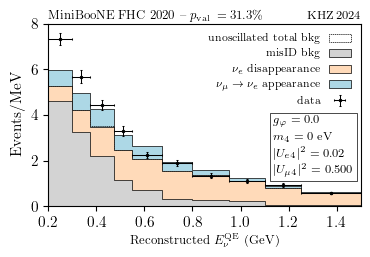

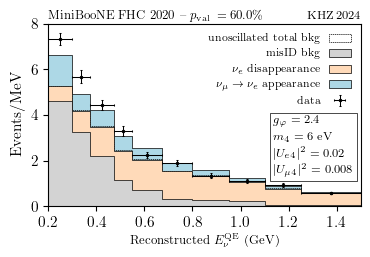

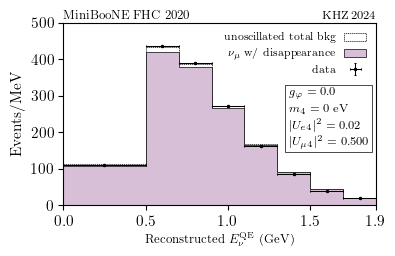

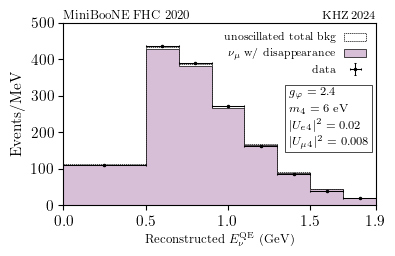

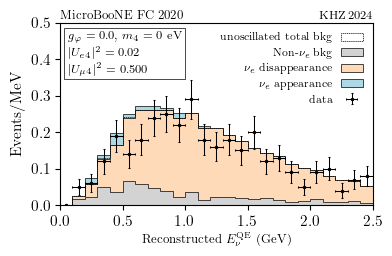

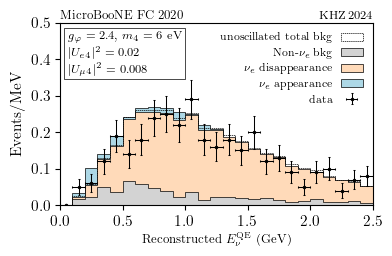

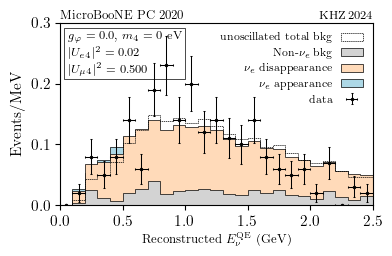

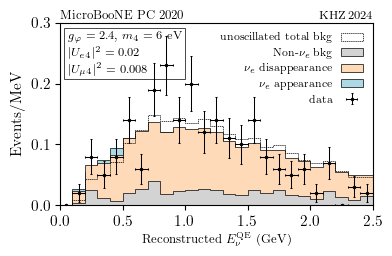

In [31]:
make_rate_plot(rates_dic_bf_osc_full, bf_osc_full, '3+1_osc_bf')
make_rate_plot(rates_dic_bf_dec_full, bf_dec_full, '3+1_dec_bf')

make_numu_rate_plot(rates_dic_bf_osc_full, bf_osc_full, '3+1_osc_bf')
make_numu_rate_plot(rates_dic_bf_dec_full, bf_dec_full, '3+1_dec_bf')

make_micro_rate_plot(rates_dic_bf_osc_full, bf_osc_full, '3+1_osc_bf')
make_micro_rate_plot(rates_dic_bf_dec_full, bf_dec_full, '3+1_dec_bf')

make_micro_rate_plot(rates_dic_bf_osc_full, bf_osc_full, '3+1_osc_bf', PC=True)
make_micro_rate_plot(rates_dic_bf_dec_full, bf_dec_full, '3+1_dec_bf', PC=True)

/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_8347/2715655352.py:17: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  open_text(
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_8347/2715655352.py:23: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  open_text(


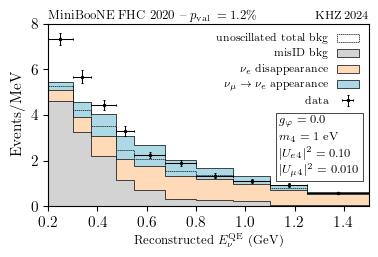

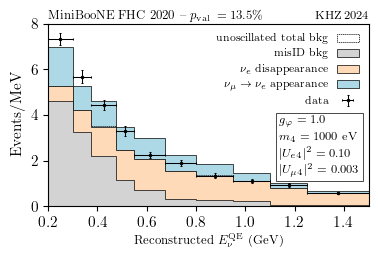

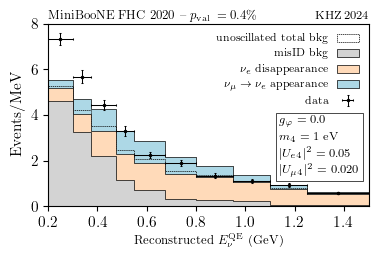

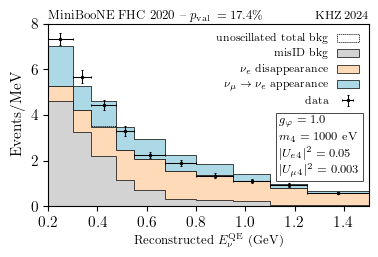

In [40]:
make_rate_plot(rates_dic_osc_BEST, params_BEST_osc, '3+1_osc_BEST')
make_rate_plot(rates_dic_decay_BEST, params_BEST_dec, '3+1_dec_BEST')

make_rate_plot(rates_dic_osc_solar, params_solar_osc, '3+1_osc_solar')
make_rate_plot(rates_dic_decay_solar, params_solar_dec, '3+1_dec_solar')

In [27]:
def make_numu_rate_plot(rates, params, name='3+1_osc'):
    fig, ax1 = pt.std_fig(figsize=(3.3*1.2,2*1.2))
    bins = param_scan.MB_Ereco_official_bins_numu
    bin_w = np.diff(bins)
    bin_c = bins[:-1] + bin_w/2

    ######################################
    # MiniBooNE 
    if TOTAL_RATE:
        units= 1
        ax1.set_ylabel(r"Events")
    else:
        units = 1/bin_w/1e3
        ax1.set_ylabel(r"Events/MeV")

    numu_data = np.genfromtxt(
        open_text(
            f"MiniTools.include.MB_data_release_2020.combined",
            f"miniboone_numudata.txt",
        )
    )
    numu_tot_bkg = np.genfromtxt(
                open_text(
                    f"MiniTools.include.MB_data_release_2020.combined",
                    f"miniboone_numu.txt",
                )
            )

    # plot data
    pt.data_plot(ax1, 
            X=bin_c,
            Y=numu_data*units, 
            xerr=bin_w/2, 
            yerr=np.sqrt(numu_data)*units,
            zorder=3)


    ax1.hist(bins[:-1],
            bins=bins,
            weights=(numu_tot_bkg)*units,
            edgecolor='black',
            lw=0.5,
            ls=(1,(2,1)),
            label=r'unoscillated total bkg',
            histtype='step',
            zorder=1.6)
    
    ax1.hist(bins[:-1],
            bins=bins,
            weights=rates['MC_numu_bkg_total_w_dis']*units,
            edgecolor='black',
            facecolor='thistle',
            lw=0.5,
            label=r'$\nu_\mu$ w/ disappearance',
            histtype='stepfilled',
            zorder=1.6)


    ax1.legend(fontsize=8, markerfirst=False, ncol=1)
    ax1.annotate(text=r'MiniBooNE FHC 2020', xy=(0.0,1.025), xycoords='axes fraction', fontsize=9)
    ax1.annotate(text=rf'\noindent $g_\varphi = {params["g"]:.1f}$\\$m_4 = {params["m4"]:.0f}$ eV\\$|U_{{e4}}|^2 = {params["Ue4Sq"]:.2f}$\\$|U_{{\mu 4}}|^2 = {params["Um4Sq"]:.3f}$', 
                 xy=(0.72,0.6), 
                 xycoords='axes fraction', 
                 fontsize=8.5,
                 bbox=dict(facecolor='none', edgecolor='black', linewidth=0.5, boxstyle='square,pad=0.3'))
    ax1.set_xlabel(r"Reconstructed $E_\nu^{\rm QE}$ (GeV)", fontsize=9, labelpad=2.5)
    ax1.set_xticks([0,0.5,1.0,1.5,1.9])
    ax1.set_xlim(0.0,1.9)
    ax1.set_ylim(0,500)

    ax1.annotate(text=PAPER_TAG, xy=(1,1.025), xycoords='axes fraction', fontsize=8.5, ha='right')

    # fig.savefig(f"{PATH_PLOTS}/Mini_{name}_numu.png", dpi=400)
    fig.savefig(f"{PATH_PLOTS}/Mini_{name}_numu.pdf", dpi=400)

/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_8347/1339146044.py:17: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  open_text(
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_8347/1339146044.py:23: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  open_text(


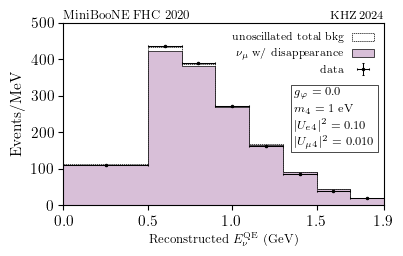

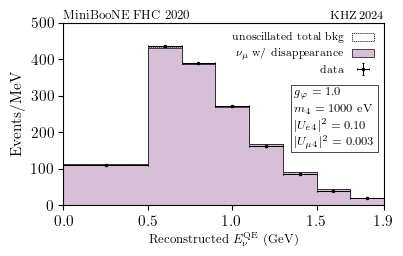

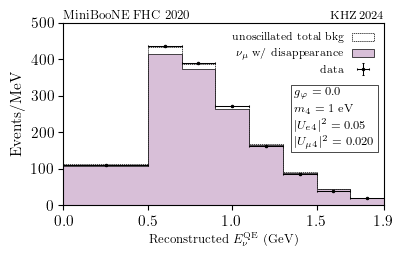

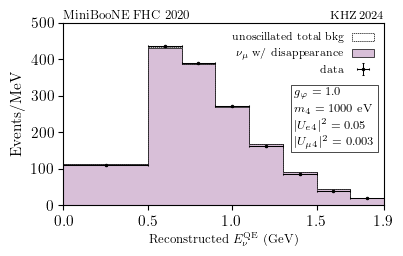

In [42]:
make_numu_rate_plot(rates_dic_osc_BEST, params_BEST_osc, '3+1_osc_BEST')
make_numu_rate_plot(rates_dic_decay_BEST, params_BEST_dec, '3+1_dec_BEST')

make_numu_rate_plot(rates_dic_osc_solar, params_solar_osc, '3+1_osc_solar')
make_numu_rate_plot(rates_dic_decay_solar, params_solar_dec, '3+1_dec_solar')

## MicroBooNE Rates

In [28]:
from MicroTools.InclusiveTools.inclusive_osc_tools import (
    Decay_muB_OscChi2,
    DecayMuBNuMuDis,
    DecayMuBNuEDis,
)

In [51]:
import copy
def make_micro_rate_plot(rates, params, name='micro_3+1_osc', PC=False):
    fig, ax1 = pt.std_fig(figsize=(3.3*1.2,2*1.2))

    bins = np.array([0.0 + 0.1 * j for j in range(26)] + [10.0])
    bin_w = np.diff(bins)
    bin_c = bins[:-1] + bin_w/2



    # MicroBooNE fully inclusive signal by unfolding MiniBooNE Signal
    uBFC = param_scan.GBFC.miniToMicro(rates["MC_nue_app_for_unfolding"])
    uBFC = np.insert(uBFC, 0, [0.0])
    uBFC = np.append(uBFC, 0.0)

    # MicroBooNE partially inclusive signal by unfolding MiniBooNE Signal
    MC_nue_app_for_unfolding2 = copy.deepcopy(rates["MC_nue_app_for_unfolding"])
    uBPC = param_scan.GBPC.miniToMicro(MC_nue_app_for_unfolding2)
    uBPC = np.insert(uBPC, 0, [0.0])
    uBPC = np.append(uBPC, 0.0)

    uBtemp = np.concatenate([uBFC, uBPC, np.zeros(85)])

    uB_signal = uBPC if PC else uBFC
#     unfolding = micro.unfolder.MBtomuB(
#     analysis="1eX_PC" if PC else "1eX",
#     remove_high_energy=False,
#     unfold=True,
#     effNoUnfold=True,
#     which_template="2020",
#     )

    # MicroBooNE fully inclusive signal by unfolding MiniBooNE Signal
#     uB_signal = unfolding.miniToMicro(rates["MC_nue_app_for_unfolding"])
#     uB_signal = np.insert(uB_signal, 0, [0.0])
#     uB_signal = np.append(uB_signal, 0.0)

    SAMPLE = "PC" if PC else "FC"
    other_bkg = np.load(micro.muB_inclusive_datarelease_path + f'nueCC_{SAMPLE}_Bkg.npy')
    intrinsic_bkg = np.load(micro.muB_inclusive_datarelease_path + f'nueCC_{SAMPLE}_Sig.npy')
    data = np.load(micro.muB_inclusive_datarelease_path + f'nueCC_{SAMPLE}_Obs.npy')

    # \nu_e disappearance signal replacement
    NuEReps = DecayMuBNuEDis(
    params,
    oscillations=True,
    decay=True,
    decouple_decay=False,
    disappearance=True,
    energy_degradation=True,
    )

    # \nu_mu disappearance signal replacement
    
    NuMuReps = DecayMuBNuEDis(
    params,
    oscillations=True,
    decay=True,
    decouple_decay=False,
    disappearance=True,
    energy_degradation=True,
    )

    # MicroBooNE
    MuB_chi2 = Decay_muB_OscChi2(
        params,
        uBtemp,
        constrained=False,
        sigReps=[NuEReps[0], NuEReps[1], NuMuReps[0], NuMuReps[1], None, None, None],
        RemoveOverflow=True,
        oscillations=True,
        decay=True,
        decouple_decay=False,
        disappearance=True,
        energy_degradation=True,
    )

    ###################################### 
    if TOTAL_RATE:
        units= 1
        ax1.set_ylabel(r"Events")
    else:
        units = 1/bin_w/1e3
        ax1.set_ylabel(r"Events/MeV")

    # plot data
    pt.data_plot(ax1, 
            X=bin_c,
            Y=data*units, 
            xerr=bin_w/2, 
            yerr=np.sqrt(data)*units,
            zorder=3)


    ax1.hist(bins[:-1],
            bins=bins,
            weights=(other_bkg + intrinsic_bkg)*units,
            edgecolor='black',
            lw=0.5,
            ls=(1,(2,1)),
            label=r'unoscillated total bkg',
            histtype='step',
            zorder=1.8)
    ax1.hist(bins[:-1],
            bins=bins,
            weights=other_bkg*units,
            edgecolor='black',
            facecolor='lightgrey',
            lw=0.5,
            label=r'Non-$\nu_e$ bkg',
            histtype='stepfilled',
            zorder=1.7)
    ax1.hist(bins[:-1],
            bins=bins,
            weights=(other_bkg+NuEReps[1 if PC else 0])*units,
            edgecolor='black',
            facecolor='peachpuff',
            lw=0.5,
            label=r'$\nu_e$ disappearance',
            histtype='stepfilled',
            zorder=1.6)
    ax1.hist(bins[:-1],
            bins=bins,
            weights=(uB_signal+NuEReps[1 if PC else 0])*units,
            edgecolor='black',
            facecolor='lightblue',
            lw=0.5,
            label=r'$\nu_e$ appearance',
            histtype='stepfilled',
            zorder=1.4)

    ax1.legend(loc='upper right', fontsize=8, markerfirst=False, ncol=1)
    ax1.annotate(text=fr'MicroBooNE {"PC" if PC else "FC"} 2020 $\vert$ $\Delta \chi^2 = {MuB_chi2:.0f}$', xy=(0.0,1.025), xycoords='axes fraction', fontsize=9)
    ax1.annotate(text=rf'\noindent $g_\varphi = {params["g"]:.1f},\, m_4 = {params["m4"]:.0f}$ eV\\$|U_{{e4}}|^2 = {params["Ue4Sq"]:.2f}\\|U_{{\mu 4}}|^2 = {params["Um4Sq"]:.3f}$', 
                 xy=(0.025,0.91), 
                 xycoords='axes fraction', 
                 fontsize=8.5,
                 bbox=dict(facecolor='none', edgecolor='black', linewidth=0.5, boxstyle='square,pad=0.3'))

    ax1.set_xlabel(r"Reconstructed $E_\nu^{\rm QE}$ (GeV)", fontsize=9, labelpad=2.5)
    ax1.set_xticks([0,0.5,1.0,1.5,2.0, 2.5])
    ax1.set_xlim(0.0,2.5)
    ax1.set_ylim(0,0.3 if PC else 0.5)

    ax1.annotate(text=PAPER_TAG, xy=(1,1.025), xycoords='axes fraction', fontsize=8.5, ha='right')

#     fig.savefig(f"{PATH_PLOTS}/Micro_{name}_{'PC' if PC else 'FC'}.png", dpi=400)
    fig.savefig(f"{PATH_PLOTS}/Micro_{name}_{'PC' if PC else 'FC'}.pdf", dpi=400)

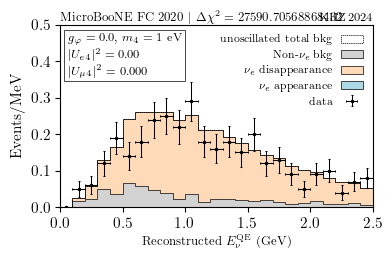

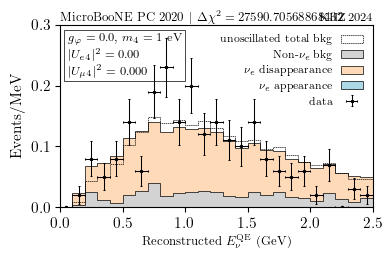

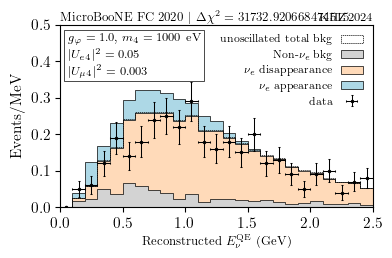

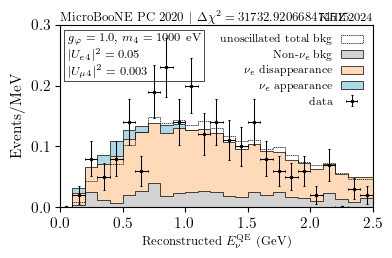

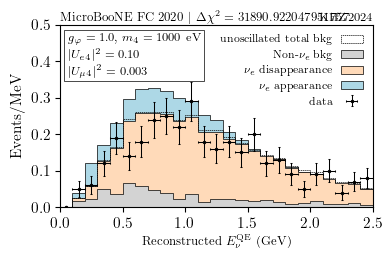

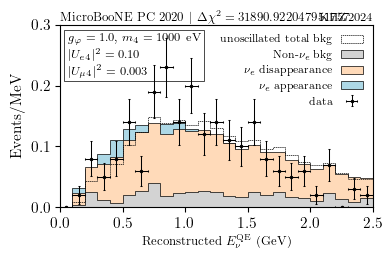

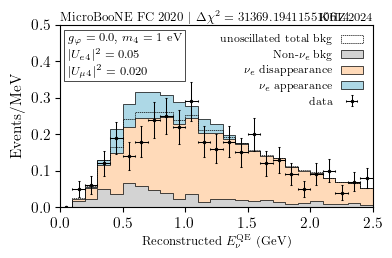

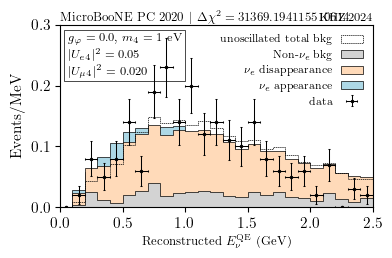

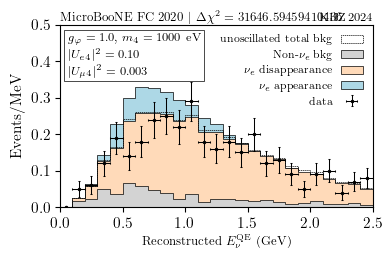

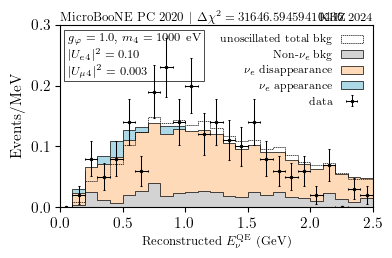

In [53]:
make_micro_rate_plot(rates_no_osc, params_no_osc, 'No osc')
make_micro_rate_plot(rates_no_osc, params_no_osc, 'No osc', PC=True)

make_micro_rate_plot(rates_dic_decay_solar, params_solar_dec, '3+1_dec_BEST')
make_micro_rate_plot(rates_dic_decay_solar, params_solar_dec, '3+1_dec_BEST', PC=True)

make_micro_rate_plot(rates_dic_decay_BEST, params_BEST_dec, '3+1_dec_BEST')
make_micro_rate_plot(rates_dic_decay_BEST, params_BEST_dec, '3+1_dec_BEST', PC=True)

make_micro_rate_plot(rates_dic_osc_solar, params_solar_osc, '3+1_osc_solar')
make_micro_rate_plot(rates_dic_osc_solar, params_solar_osc, '3+1_osc_solar', PC=True)

make_micro_rate_plot(rates_dic_osc_BEST, params_BEST_dec, '3+1_osc_BEST')
make_micro_rate_plot(rates_dic_osc_BEST, params_BEST_dec, '3+1_osc_BEST', PC=True)